# IMPORTANDO E CRIANDO DATAFRAME

In [ ]:
#@title Bibliotecas
import pandas as pd
import numpy as np

import kagglehub

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer

import matplotlib.pyplot as plt
import re
import gc


In [ ]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt_tab')
#from gensim.models import Word2Vec



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'


In [ ]:
#@title Importa o DataSet do Kaggle

#import kagglehub
#ernestocarlosbode_books_metadata_with_topics_path = kagglehub.dataset_download('ernestocarlosbode/books-metadata')


ernestocarlosbode_books_metadata_path = kagglehub.dataset_download('ernestocarlosbode/books-metadata')


print('Data source import complete.')
print(ernestocarlosbode_books_metadata_path)

!ls /root/.cache/kagglehub/datasets/ernestocarlosbode/books-metadata/versions/1

100%|██████████| 7.43M/7.43M [00:01<00:00, 4.42MB/s]

Extracting files...


Data source import complete.
/root/.cache/kagglehub/datasets/ernestocarlosbode/books-metadata/versions/1
df_short_livro.csv


In [ ]:
#@title Criando o DataFrame df
file_path = f'{ernestocarlosbode_books_metadata_path}/df_short_livro.csv' #<< nome do arquivo no Kaggle
df = pd.read_csv(file_path, sep=';')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182811 entries, 0 to 182810
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   autor        142237 non-null  object 
 1   título       182811 non-null  object 
 2   imprenta     182801 non-null  object 
 3   material     182811 non-null  object 
 4   coleção      0 non-null       float64
 5   localização  181799 non-null  object 
 6   descrição    37850 non-null   object 
 7   data tombo   179624 non-null  object 
 8   exemplar     7015 non-null    object 
dtypes: float64(1), object(8)
memory usage: 12.6+ MB


# PRÉ-PROCESSAMENTO

inclui:


*   renomear colunas
*   remover caracteres
*   definir "slices" de dataFrame por classe CDU
*   definir a classe CDU de trabalho


---







In [ ]:
#@title Renomeando colunas com nomes mais curtos

df = df.rename(columns={
    'autor': 'author',
    'título': 'title',
    'imprenta': 'publish',
    'material': 'type',
    'coleção': 'collection',
    'localização': 'CDU',
    'descrição': 'description',
    'data tombo': 'dt_load',
    'exemplar': 'copies'
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182811 entries, 0 to 182810
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   author       142237 non-null  object 
 1   title        182811 non-null  object 
 2   publish      182801 non-null  object 
 3   type         182811 non-null  object 
 4   collection   0 non-null       float64
 5   CDU          181799 non-null  object 
 6   description  37850 non-null   object 
 7   dt_load      179624 non-null  object 
 8   copies       7015 non-null    object 
dtypes: float64(1), object(8)
memory usage: 12.6+ MB


In [ ]:
#@title Dataframe sem títulos repetidos

df_unique = df.drop_duplicates(subset=['title'])

df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131296 entries, 0 to 182810
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   author       102164 non-null  object 
 1   title        131296 non-null  object 
 2   publish      131288 non-null  object 
 3   type         131296 non-null  object 
 4   collection   0 non-null       float64
 5   CDU          130457 non-null  object 
 6   description  12205 non-null   object 
 7   dt_load      128783 non-null  object 
 8   copies       1994 non-null    object 
dtypes: float64(1), object(8)
memory usage: 10.0+ MB


In [ ]:
#@title Pré-Processamento: acrescentar coluna Class_CDU
#(para definição da Classe operacional, ou de trabalho)


def extract_first_digit(text):
  if pd.isna(text) or not isinstance(text, str):
    return None
  match = re.search(r'\d', text)
  if match:
    return match.group(0)
  else:
    return None

df_unique['Class_CDU'] = df['CDU'].apply(extract_first_digit)

df_unique.info()


<class 'pandas.core.frame.DataFrame'>
Index: 131296 entries, 0 to 182810
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   author       102164 non-null  object 
 1   title        131296 non-null  object 
 2   publish      131288 non-null  object 
 3   type         131296 non-null  object 
 4   collection   0 non-null       float64
 5   CDU          130457 non-null  object 
 6   description  12205 non-null   object 
 7   dt_load      128783 non-null  object 
 8   copies       1994 non-null    object 
 9   Class_CDU    130457 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.0+ MB


In [ ]:
#@title Pré-processando: função preprocess_text

def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # or handle non-string values as needed

    text = re.sub(r'[^\w\s]', '', text) # Remove pontuação
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('portuguese'))
    tokens = [w for w in tokens if not w in stop_words]
    stemmer = RSLPStemmer()
    stemmed_tokens = [stemmer.stem(w) for w in tokens]
    return " ".join(stemmed_tokens)

#@title Aplicando pré-processamento nas colunas escolhidas
df_unique['title_processed'] = df_unique['title'].apply(preprocess_text)
df_unique['CDU_processed'] = df_unique['CDU'].apply(preprocess_text)

# EMBEDDING BERT

In [ ]:
# prompt: verificar a versão da biblioteca numpy instalada

import numpy as np

np.__version__


'2.0.2'

In [ ]:
!pip install transformers sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

#model_name = 'bert-base-nli-mean-tokens'
#model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the SentenceTransformer model with specified parameters
model = SentenceTransformer(model_name, device=device)
model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [ ]:

# Calculate embeddings for 'title_processed'
df_unique['title_embeddings'] = df_unique['title_processed'].apply(lambda x: model.encode(x))

# Calculate embeddings for 'CDU_processed'
df_unique['CDU_embeddings'] = df_unique['CDU_processed'].apply(lambda x: model.encode(x))


In [ ]:
#@title SALVANDO DF_UNIQUE COM EMBEDDINGS

from google.colab import drive
drive.mount('/content/drive')

# Assuming df_unique is already defined as in your provided code.
df_unique.to_csv('[DEFINIR LOCAL PARA SALVAR O ARQUIVO]/df_uniqueall-paraphrase-multilingual.csv', sep=';', encoding='utf-8', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# SLICES DATAFRAME POR CLASSES

In [ ]:
#@title Classes CDU no DataFrame df

# Display and count unique values in the 'coleção' column, excluding NaN values
unique_classes = df_unique['Class_CDU'].dropna().unique()
print(unique_classes)
print("\nNumber of unique values:", len(unique_classes))


['9' '8' '1' '3' '0' '6' '2' '5' '7']

Number of unique values: 9


In [ ]:
#@title DataFrames Slice's para cada classe CDU

# Loop through unique collections
for classe in unique_classes:
    # Slice the DataFrame for the current class
    df_slice = df_unique[df_unique['Class_CDU'] == classe]

    # Create a new DataFrame with the name df_slice_{collection}
    globals()[f'df_slice_{classe}'] = df_slice

# mostrando os dataframes slices por classe CDU
all_objects = dir()
df_slice_objects = [obj for obj in all_objects if obj.startswith("df_slice_")]
df_slice_objects


['df_slice_0',
 'df_slice_1',
 'df_slice_2',
 'df_slice_3',
 'df_slice_5',
 'df_slice_6',
 'df_slice_7',
 'df_slice_8',
 'df_slice_9',
 'df_slice_objects']

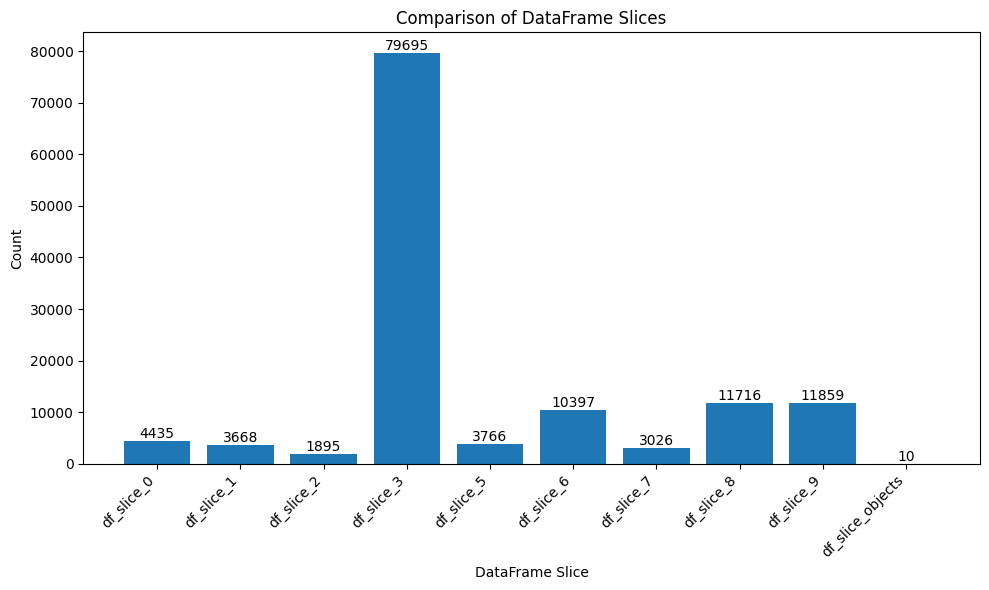

In [ ]:
import matplotlib.pyplot as plt

# Create a list to store the counts for each DataFrame
counts = []

# Iterate over each df_slice object
for obj_name in df_slice_objects:
  # Get the DataFrame using globals()
  df_slice = globals()[obj_name]

  # Count the number of rows (or any relevant metric)
  counts.append(len(df_slice))

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
bars = plt.bar(df_slice_objects, counts)

# Add labels above the bars with their values
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel("DataFrame Slice")
plt.ylabel("Count")
plt.title("Comparison of DataFrame Slices")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
#@title Classe CDU para trabalho (trabalho uma classe por vez)
"""
aqui escolhemos uma das classes do DataFrame df_slice_objects. Isto é necessário
em função da quantidade total de linhas ser muito alta.
Trabalhando com uma classe por vez, minimizamos este problema.
"""

df_chosenClass = df_slice_9 #@param < classe escolhida

print('Número total de títulos (únicos) nesta classe >> ', len(df_chosenClass.title))
print("-" * 20)
#print(f'Classe Escolhida: {class_folder}')
print("-" * 20)
df_chosenClass.info()

Número total de títulos (únicos) nesta classe >>  11859
--------------------
--------------------
<class 'pandas.core.frame.DataFrame'>
Index: 11859 entries, 0 to 182803
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   author                    10222 non-null  object 
 1   title                     11859 non-null  object 
 2   publish                   11858 non-null  object 
 3   type                      11859 non-null  object 
 4   collection                0 non-null      float64
 5   CDU                       11859 non-null  object 
 6   description               1624 non-null   object 
 7   dt_load                   11686 non-null  object 
 8   copies                    456 non-null    object 
 9   Class_CDU                 11859 non-null  object 
 10  title_processed           11859 non-null  object 
 11  CDU_processed             11859 non-null  object 
 12  title_embeddings      

# CLUSTERIZAÇÃO (em df_chosenClass)


---



In [ ]:
from sklearn.cluster import KMeans

# Concatenate title and CDU embeddings
df_chosenClass['combined_bert_embeddings'] = df_chosenClass.apply(lambda row: np.concatenate((row['title_embeddings'],
                                                                                              row['CDU_embeddings'])), axis=1)
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=0)
df_chosenClass['cluster'] = kmeans.fit_predict(np.stack(df_chosenClass['combined_bert_embeddings']))


# GRÁFICOS VISUALIZAÇÃO

o quanto são esféricos


---



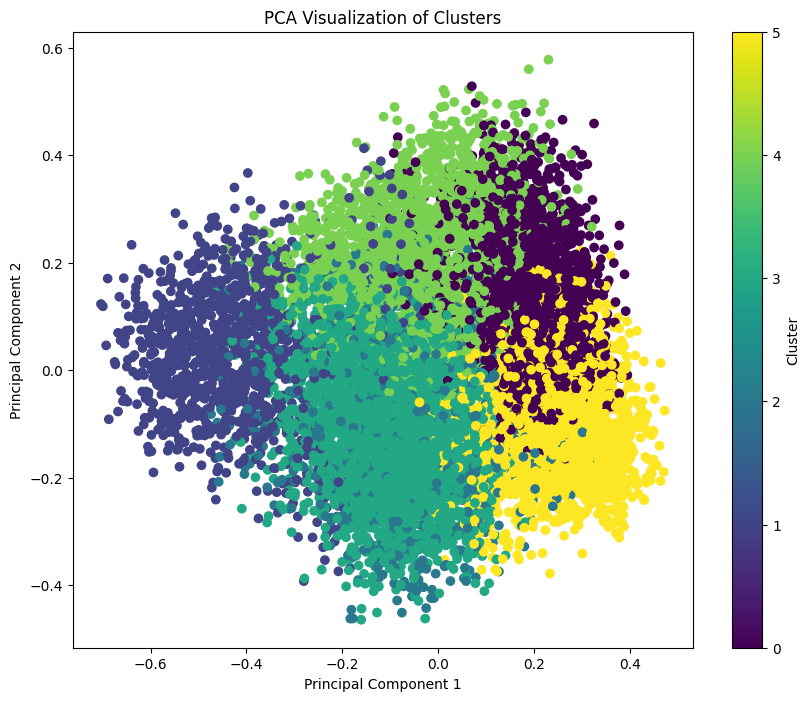

In [ ]:
#@title Visualização PCA

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(np.stack(df_chosenClass['combined_bert_embeddings']))

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_chosenClass['cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# prompt: gerar gráfico TSNE (sklearn.manifold) para visualização dos cluster em df_chosenClass.['clusters']

from sklearn.manifold import TSNE

# Use TSNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(np.stack(df_chosenClass['combined_bert_embeddings']))

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df_chosenClass['cluster'])
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()


# EXPORTAR PARA ANÁLISE LLM

In [ ]:
#@title Exportando...

df_chosenClass.to_csv('[DEFINIR LOCAL PARA SALVAR]/df_uniqueall-paraphrase-multilingual.csv', sep=';', encoding='utf-8', index=False) # exportando classe 9 com 6 clusters
